# Curvy-CUSIPs: Conditional Trades

In [1]:
import sys
sys.path.append("../")

In [27]:
import pandas as pd
from datetime import datetime 
from pandas.tseries.offsets import CustomBusinessDay, BDay 
from pandas.tseries.holiday import USFederalHolidayCalendar

from CurvyCUSIPs.CurveDataFetcher import CurveDataFetcher
from CurvyCUSIPs.S490Swaps import S490Swaps
from CurvyCUSIPs.S490Swaptions import S490Swaptions

from CurvyCUSIPs.utils.regression_utils import run_basic_linear_regression_df, run_multiple_linear_regression_df, plot_residuals_timeseries
import CurvyCUSIPs.HedgeHog.swaps as hh_swaps

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
plt.style.use('ggplot')
params = {'legend.fontsize': 'large',
        'figure.figsize': (12, 8),
        'axes.labelsize': 'large',
        'axes.titlesize':'large',
        'xtick.labelsize':'large',
        'ytick.labelsize':'large'}
pylab.rcParams.update(params)

import nest_asyncio
nest_asyncio.apply()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
curve_data_fetcher = CurveDataFetcher()

In [6]:
s490_swaps = S490Swaps(s490_curve_db_path=r"..\db\nyclose_sofr_ois", curve_data_fetcher=curve_data_fetcher)
s490_swaptions = S490Swaptions(s490_swaps)

start_date = datetime(2024, 1, 1)
end_date = datetime(2025, 1, 2)
bdates = pd.date_range(start=start_date, end=end_date, freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))

..\db\s490_swaption_atm_vol is behind --- cd into 'scripts' and run 'update_atm_swaption_vol.py' to update --- most recent date in db: 2025-01-07 00:00:00


In [38]:
fwd_tenors = ["3M", "6M"]
fwd_grid_dict, ql_curves = s490_swaps.s490_nyclose_fwd_curve_matrices(
    start_date=start_date,
    end_date=end_date,
    ql_piecewise_method="logLinearDiscount",
    fwd_tenors=fwd_tenors,
)

Building Implied Fwd Curves...: 100%|██████████| 252/252 [00:00<00:00, 275.64it/s]


In [13]:
vol_cube_dict = s490_swaptions.get_vol_cube(date=end_date)
ql_vol_cube_handle = s490_swaptions.get_ql_vol_cube_handle(vol_cube_dict=vol_cube_dict)

BUILDING OIS SWAP TIMESERIES DF...: 100%|██████████| 252/252 [00:00<00:00, 599.50it/s]


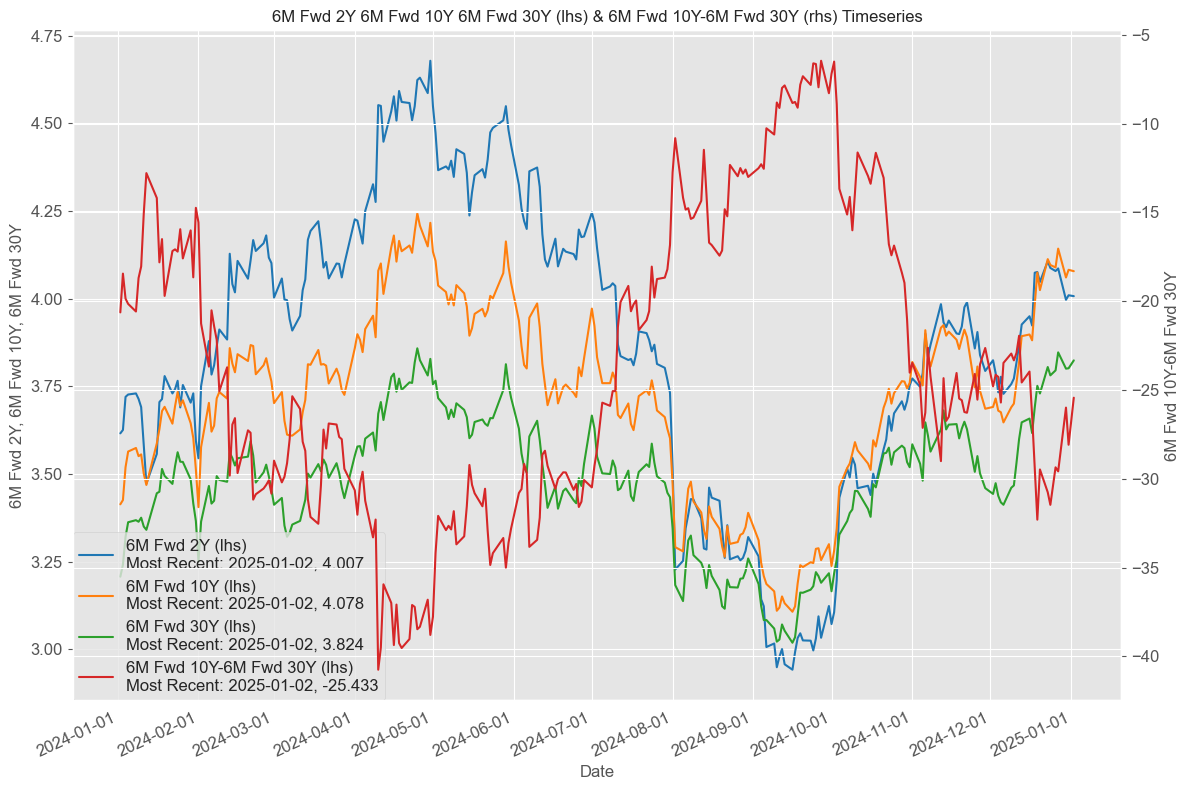

,Date,6M Fwd 2Y,6M Fwd 10Y,6M Fwd 30Y,6M Fwd 10Y-6M Fwd 30Y
0,2024-01-02,3.615861,3.413583,3.207303,-20.628095
1,2024-01-03,3.625584,3.425692,3.241247,-18.444563
2,2024-01-04,3.719834,3.519375,3.320819,-19.855589
3,2024-01-05,3.726574,3.563985,3.362479,-20.150634
4,2024-01-08,3.729698,3.574173,3.368391,-20.578264
...,...,...,...,...,...
246,2024-12-26,4.078596,4.088883,3.795348,-29.353480
247,2024-12-27,4.086029,4.142525,3.846725,-29.580030
248,2024-12-30,3.996587,4.060242,3.800339,-25.990319
249,2024-12-31,4.009472,4.082139,3.801318,-28.082130


In [25]:
ts_swaps_df = s490_swaps.timeseries_builder(
    fwd_dict_df=fwd_grid_dict,
    cols=["6M Fwd 2Y", "6M Fwd 10Y", "6M Fwd 30Y", "6M Fwd 10Y-6M Fwd 30Y"],
    start_date=start_date,
    end_date=end_date,
    tenor_is_df_index=True,
    scale_curve=True,
)

s490_swaps._general_df_plotter(df=ts_swaps_df, cols_to_plot=["6M Fwd 2Y", "6M Fwd 10Y", "6M Fwd 30Y"], cols_to_plot_raxis=["6M Fwd 10Y-6M Fwd 30Y"])

ts_swaps_df

FETCHING VOL TIMESERIES: 100%|██████████| 252/252 [00:00<00:00, 315.63it/s]


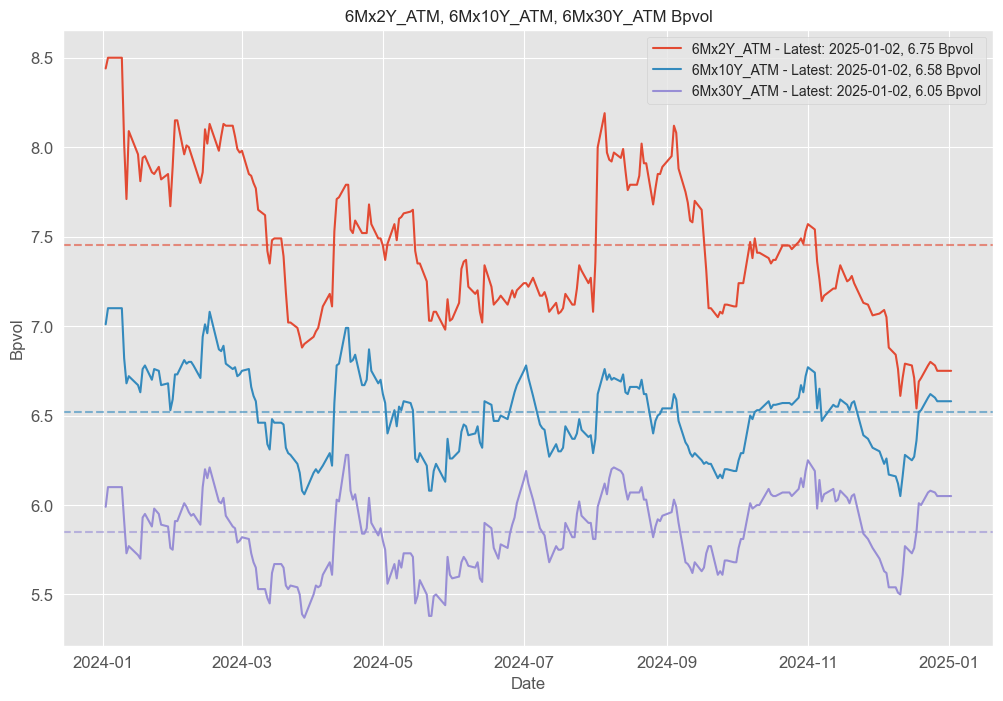

,Date,6Mx2Y_ATM,6Mx10Y_ATM,6Mx30Y_ATM
0,2024-01-02,8.44,7.01,5.99
1,2024-01-03,8.50,7.10,6.10
2,2024-01-04,8.50,7.10,6.10
3,2024-01-05,8.50,7.10,6.10
4,2024-01-08,8.50,7.10,6.10
...,...,...,...,...
242,2024-12-26,6.78,6.60,6.07
243,2024-12-27,6.75,6.58,6.05
244,2024-12-30,6.75,6.58,6.05
245,2024-12-31,6.75,6.58,6.05


In [23]:
ts_swaptions_df = s490_swaptions.get_vol_timeseries(
    tenor_strike_pairs=[("6Mx2Y", 0), ("6Mx10Y", 0), ("6Mx30Y", 0)], start_date=start_date, end_date=end_date, one_df=True, plot_timeseries=True
)
ts_swaptions_df

## Delivered/Realized Directionality/Beta:

In [34]:
(datetime(2025, 1, 8) - BDay(60)).to_pydatetime()

datetime.datetime(2024, 10, 16, 0, 0)

In [62]:
"3M Fwd 10Y".replace(" Fwd ", "x")

'3Mx10Y'

In [73]:
short_mat = "3M Fwd 2Y"
long_mat = "3M Fwd 10Y"

temp_df = s490_swaps.timeseries_builder(
    fwd_dict_df=fwd_grid_dict,
    cols=[short_mat, long_mat],
    start_date=datetime(2025, 1, 6) - BDay(60),
    end_date=datetime(2025, 1, 6),
    tenor_is_df_index=True,
)

rr = run_basic_linear_regression_df(df=temp_df, x_col=long_mat, y_col=short_mat, no_plot=True)

temp_vol_df = s490_swaptions.get_vol_timeseries(
    tenor_strike_pairs=[(short_mat.replace(" Fwd ", "x"), 0), (long_mat.replace(" Fwd ", "x"), 0)],
    start_date=datetime(2025, 1, 6),
    end_date=datetime(2025, 1, 6),
    one_df=True,
)

print(
    f"Implied Directionality: {1 - (temp_vol_df[f"{short_mat.replace(" Fwd ", "x")}_ATM"].iloc[-1] / temp_vol_df[f"{long_mat.replace(" Fwd ", "x")}_ATM"].iloc[-1])}"
)
print(f"Delivered Directionality: {1 - rr.params.values[1]}")

FETCHING VOL TIMESERIES: 100%|██████████| 1/1 [00:00<00:00, 390.60it/s]

Implied Directionality: -0.04160000000000008
Delivered Directionality: 0.09955182952047115


In [74]:
1 - (6.61 / 6.33)

-0.04423380726698256

In [217]:
swaption_book_metrics_dict = hh_swaptions.swaption_book_metrics(
    underlyings=book, ql_curve=ql_curves[trade_date], ql_yts=s490_swaps._ql_yts, ql_sofr=s490_swaps._ql_sofr, swaption_vol_handle=ql_vol_cube_handle 
)
swaption_book_metrics_dict

PRICING SWAPTIONS...: 100%|██████████| 6/6 [00:00<00:00, 12.80it/s]


{'12M Fwd 5Y_rec': {'atm_strike': np.float64(0.03147240042442179),
  'strike': np.float64(0.03147240042442179),
  'strike_offset_bps': np.float64(0.0),
  'npv': np.float64(1978669.3233237292),
  'normal_vol': np.float64(111.82511746425493),
  'bpvol': np.float64(7.044320265262008),
  'spot_prem_bps': 197.86693233237293,
  'fwd_prem_bps': 206.51552947527927,
  'ql': {'swaption': <QuantLib.QuantLib.Swaption; proxy of <Swig Object of type 'ext::shared_ptr< Swaption > *' at 0x000001AA0AC88150> >,
   'underlying': <QuantLib.QuantLib.OvernightIndexedSwap; proxy of <Swig Object of type 'ext::shared_ptr< OvernightIndexedSwap > *' at 0x000001AA0AC893E0> >},
  'greeks': {'dv01': np.float64(22164.60828423399),
   'gamma_01': np.float64(158.66853431204981),
   'vega_01': np.float64(17790.40102440059),
   'volga_01': np.float64(2.2370564875018317),
   'vanna_01': np.float64(-1902.01512130443),
   'theta_1d': np.float64(-2232.975238713203),
   'charm_1d': np.float64(-0.023622080432687653),
   'veta_

In [180]:
vol_cube_dict = s490_swaptions.get_vol_cube(date=trade_date)

In [182]:
swaption_book_metrics_dict = hh_swaptions.swaption_book_metrics_parallel(
    underlyings=book,
    ql_curve=ql_curves[trade_date],
    sofr_fixings_dates=s490_swaps._sofr_fixing_dates,
    sofr_fixings=s490_swaps._sofr_fixings,
    vol_cube_dict=vol_cube_dict,
    n_jobs=-1
)
swaption_book_metrics_dict

PRICING SWAPTIONS...: 100%|██████████| 6/6 [00:00<00:00, 7621.39it/s]
CLEANING UP...: 6it [00:00, 18065.92it/s]


{'1M Fwd 10Y': {'atm_strike': np.float64(0.033588757050794005),
  'strike': np.float64(0.033588757050794005),
  'strike_offset_bps': np.float64(0.0),
  'npv': np.float64(10466.619763034289),
  'normal_vol': np.float64(104.2977286881497),
  'bpvol': np.float64(6.57013934327931),
  'spot_prem_bps': 104.66619763034288,
  'fwd_prem_bps': 105.19969288405662,
  'greeks': {'dv01': np.float64(419.4876478525386),
   'gamma_01': np.float64(10.655961322063147),
   'vega_01': np.float64(101.84320033808186),
   'volga_01': np.float64(0.3857203268609055),
   'vanna_01': np.float64(199.6035373667837),
   'theta_1d': np.float64(-161.06299231312914),
   'charm_1d': np.float64(-0.032663443071726306),
   'veta_1d': np.float64(-1.5550107946567948)}},
 '3M Fwd 10Y': {'atm_strike': np.float64(0.03334859769750609),
  'strike': np.float64(0.03334859769750609),
  'strike_offset_bps': np.float64(0.0),
  'npv': np.float64(920068.8442452768),
  'normal_vol': np.float64(110.974406167216),
  'bpvol': np.float64(6.9


"""
Notes:
Using vol to leverage macro view
- directional view => first rotation
- short vs intermediarte expiries => second rotation
- yield curve => third rotation

Spreads: buy atm, sell otm
    - limited upside, downside is premium paid
    - usually same notional i.e. 1-1 weighting
    - use terminal pv01

    
Flies: buy atm, sell otm + del, buy otm + 2 * del
    - (1, -2, 1) structure
    - 


Conditional trades:

- directionality is priced in the options market versus what the market typically delivers

- yield curve exhibiting empirical directionality:
    - steepeneing in sell off
    - flattening in rallies
    - always be attractive to buy options on long tails versus short tails i.e. conditional bear steepener or conditional bull flatteners

    - subsequent delivered directionality versus ex-ante implied directionality
        - (a rough measure of the success of the trade; the final trade has either 0 or positive P&L
        - Subsequent realized directionality* ex-ante implied directionality for the 3s/20s curve;
            - Realized directionality calculated as 3M beta of 3s/20s curve of 10Y yield. 
            - Implied directionality calculated as (1 - ratio of 3Mx3Y implied vol to 3Mx20Y implied vol).

    - prefer conditional trades when the underlying yield curve directionality is strong and is expected to hold
    - conditional bear steepener: buy long tail payer, sell short tail payer
    - conditonal bull steepener: buy short tail receiver, sell long tail receiver
    - conditional bear flattener: buy short tail payer, sell long tail payer
    - conditional bull flattener: buy long tail receiver, sell short tail receiver

    - Both the options are exercised if underlying yields increase otherwise the trade expires worthless 
      (excluding the case of curve twisting making one option in the money and the other out of the money at expiry)
    - If the yield curve has steepened in a sell-off in excess of that is currently priced in the relative implied volatility (as was the a-priori)
      then payoff from long tail payers would be higher than the losses from being short in short tail payers

    - In the event we do not have a strong view on the directional movement of the underlying yield but still believe that yield curve directionality is 
      likely to hold, we can then trade straddles versus straddles (both unhedged)

    - These trades are expected to perform only if the underlying yield curve directionality holds and they are attractive to implement only if the options
      market is not correctly pricing the recent realized directionality of the swap curve (implied directionality is cheap compared to delivered directionality)

        Implied directionality is defined as: 1 -(implied volatility of the short
        tail option/implied volatility of the long tail option). Thus, for a 3s/20s
        bear steepener, this would be calculated as 1 - (3Mx3Y/3Mx20Y).
        Delivered directionality is defined as 1 - 3M beta of short tail yield to
        long yield. In our example, this would be calculated as the 3M beta of
        3Y yield to 20Y yield. In other words, 3M beta of the 3s/20s swap
        curve to 20Y yield.

       In other word, the attractiveness of these strategies depend on the relative option implied volatilities across the curve. JPM Exhibit 5 

    - “positive” curve directionality when the central banks are on hold
    -  “negative” curve directionality when central banks are active: bear-flattening at start of hiking cycle, bull-steepening at start of easing cycle

    - short/sold options: downside is NOT limited: typically the case if the yield curve directionality completely reverse
        - most cases: conditional trades are implemented at zero-cost. 
        - if the options expire worthless (for example we hold bear steepeners and market rallies), then the downside to the trade at expiry is limited
        - option prices for ATMF options are linear in volatility, a PVBP curve weighted trade can be implemented as premium neutral trade iff volatilities 
          on the two legs of the trade are exactly the same
        - unlikely in an environment where implied volatility get priced somehow in line with historical volatility
        - can achieve this premium neutrality:
            - strike shift
            - beta weighted curve

    - strike shift strategy (shifting the strike of the options with higher implied volatility (option is traded out-of-the money))
    - Weighted curve strategy (reducing the notional on the leg with higher volatility (both legs are traded ATMF))

    - Strike shift strategy (1:1 risk weight)
        - notionals are calculated assuming equal risk exposure on both the legs; in other words, the notionals are calculated as is done for a standard curve or yield
          spread trade. 
        - Using ATMF options would, therefore, not necessarily ensure premium neutrality (unless both the options are trading at identical volatility levels in 
          which case the ATMF option premium would just be a ratio of the swap PVBP
        - strikes are typically shifted so that the options are out-of-money at inception, with a larger move OTM for the option with more expensive 
          implied volatility
        - conditional curve exposure is 1:1, i.e., Long end yield- short end yield

    - Weighted curve strategy (Implied volatility ratio risk weight)
        - premium neutrality is achieved by buying less of the more expensive option, and specifically by having the duration neutral notional adjusted 
          by the ratio of implied volatility
        - initiated with ATMF strike
        - risk weight:  (1:implied volatility ratio)
        - the exposure of the conditional trade here is to the movement of the weighted curve (weighted by the ratio of the implied volatility weights); 
          i.e., volatility ratio * Long end yield - short end yield, where volatility ratio is the implied volatility on short tail divided by the implied 
          volatility on long tail

    Details of the two types of conditional trades:

    Strike shift strategy:
    - Notional on long leg (longer tenor swaption) = 100
    - Notional on short leg (shorter tenor swaption) = 100 * (PVBP_L/PVBP_S), where PVBP is the price value of a basis point move in yield of the underlying swap.
    - two degrees of freedom with  one constraint (premium neutraliy), there is an infinite set of solutions for this exercise
        - (the set of points satisfying these conditions are what we typically call iso-premium lines
    - if we choose ATMF strike for the option with lower implied volatility which would then leave us with only one degree of freedom, able to get closed form solution
   
    - delta * (-x) + 0.5 * (gamma) * (-x)^2 = del_price 
    
""" 